We can fit a lot of models. What is a good model? One property that we want a model to have is the ability to **generalise**. That is, it should achieve low error on unseen data. Other desired property could be low training (financial) cost.

- Under/over fitting can reduce generalisation;
- High bias or variance can reduce generalisation.

# Under / Over fitting

We say a model:
- **overfits** the training set if it achieves a low error on the training set, and a high error on new examples (i.e. it fails to generalise to new examples). This can happen when the model is too flexible, i.e. it has too many parameters, making it either:
  - capture random noise in the data OR
  - make predictions unsupported by the data.
- **underfits** the training set when it achieves a high error (on the trainig set). This can happen when the models does not have enough flexibility to capture e.g. cliffs in the data.

In the example below, the model uses polynomial basis functions. When the polynomial degree is 1, the it underfits. When it's 9, it overfits.

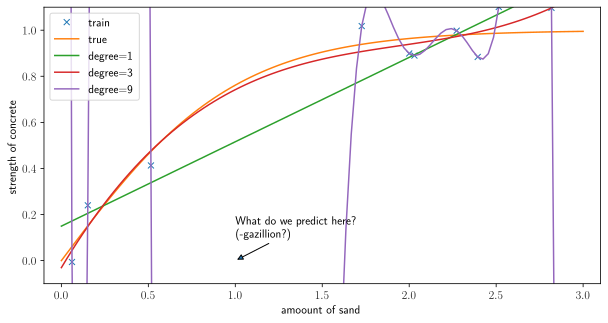

In [1]:
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12, 'text.usetex': True})

grid_size = 100
X_grid = np.linspace(0, 3, grid_size)[:, None] # [grid_size, 1]
true_f = lambda x: np.tanh(x) # the true generating function

# Build training data by taking N random points from X_grid and adding independent random normal noise to each
N = 10 # number of training points
X = np.array([0.061, 0.152, 0.515, 1.727, 2., 2.03, 2.273, 2.394, 2.515, 2.818])[:, None]
y = np.array([-0.006, 0.24, 0.413, 1.018, 0.899, 0.89, 0.998, 0.884, 1.101, 1.097])[:, None]
#X = X_grid[np.sort(np.random.choice(range(X_grid.shape[0]), N, replace=False))]
#y = G(X) + np.random.randn(X.shape[0])[:, None] / 10

def phi_poly(X, degree=3):
    return np.concatenate([X**i for i in range(degree + 1)], axis=1)


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(X, y, 'x', label='train')
ax.plot(X_grid, true_f(X_grid), label='true')

for degree in [1, 3, 9]:
    Phi = phi_poly(X, degree) # [N, 1] -> [N, K=degree + 1]
    w_fit = np.linalg.lstsq(Phi, y, rcond=None)[0] # [K, 1]

    f_grid = phi_poly(X_grid, degree).dot(w_fit) # [grid_size, 1]
    ax.plot(X_grid, f_grid, label=f'degree={degree}')

ax.annotate(
    'What do we predict here?\n(-gazillion?)', (1, 0), (1,  0.1),
    arrowprops={"arrowstyle": "-|>"}
)
ax.set(
    xlim=(-0.1, 3.1), ylim=(-0.1, 1.1),
    xlabel="amoount of sand", ylabel="strength of concrete"
)
ax.legend()
plt.show()

# How to avoid overfitting

Here are some options:
1. Get more data
2. Reduce the number of parameters
3. Regularise
4. Stop training early

## Get more data
This can prevent the model making predictions unsupported by the data. In out example above, a training point $(1, y)$ could prevent our model from dropping to negative gazillion at $1$.

## Regularise

Broadly speaking, regularization means embedding prior knowledge about how the model should be into the model. Usually the purpose of regularisation is to encourage generalisation, but can it also aim to encourage sparsity.

Here is a case study, where the goal of regularisation is to increase generalisation by discouraging extreme fits. Say our aim is to fit a linear model with basis functions $f(\underline x, \underline w) = \sum_k w_k \phi_k(\underline x)$. Consider three possible basis function choices, RBF, sigmoid, and 2nd degree polynomial. Say $|\underline x|=1$ and $k=1$.

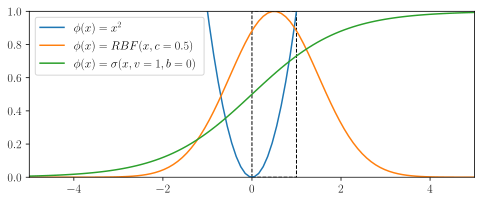

In [2]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8, 3))

x = np.linspace(-5, 5, 100)
ax.plot(x, x**2, label=r'$\phi(x) = x^2$')
ax.plot(x, np.exp(-(x - 0.5)**2 / 2), label=r'$\phi(x) = RBF(x, c=0.5)$')
ax.plot(x, 1 / (1 + np.exp(-(1 * x + 0))), label=r'$\phi(x) = \sigma(x, v=1, b=0)$')
ax.add_patch(Rectangle((0, 0), 1, 1, linestyle="--", fill=False))

ax.set(xlim=(-5, 5), ylim=(0, 1))
ax.legend()
plt.show()

### Regularisation targets
Since $f$ is a weighted sum of such basis functions, it is bounded if both the weights $w_{1:K}$ and the basis functions $phi_{1:K}$ are bounded.

- **Weight regularisation** (i.e. kernel regularisation) or bias regularisation: say basis functions are bounded. This is the case above with RBF and sigmoid. Both are bounded between 0 and 1. The 2nd degree polynomial is also bounded between 0 and 1 an a fixed domain interval, say $x \in [0, 1]$. In that case $f(x, \underline w) = \sum_k w_k \phi_k(x) \le |w_k| |\phi_k(x)| \le \sum_k |w_k|$. Thus, the boundedness of $f$ depends on the weights. We should limit the values of the weights $w_k$. This will also make the derivatives of our basis functions bounded, which is a good thing since we use basis function derivatives when fitting $f$;
- **Basis function regularisation** (i.e. activity regularisation): If the basis functions $\phi_k(x)$ are not bounded we might want to regularise them as well.

## Less-parameters regularisation

Reduce the number of parameters.
This can make the model less flexible. As a result, it will be less susceptible to wild oscillations.

Options to choose the optimal number of parameters:
1. Manually, e.g. using domain knowledge. We should not inspect the training set though, as we might adapt the model to the noise within, but fail to generalise (i.e. we might overfit the training set);
2. By comparing performance of models with different numbers of parameters on a held-out set, aka a validation set.

Here is an example of using a validation set for selecting the maximum degree for polynomial basis functions.

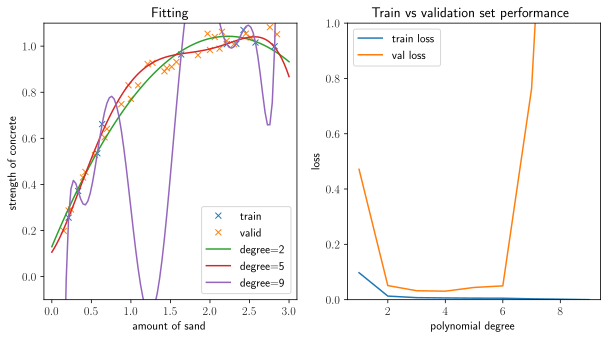

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set(
    title="Fitting", xlabel="amount of sand", ylabel="strength of concrete",
    xlim=(-0.1, 3.1), ylim=(-0.1, 1.1)
)
ax[1].set(
    title="Train vs validation set performance", xlabel="polynomial degree", ylabel="loss",
    ylim=(0, 1)
)

x_grid = np.linspace(0, 3, 100)[:, None] # [grid_size, 1]
true_f = lambda x: np.tanh(x) # the true generating function

def get_dataset(size):
    idxs = np.sort(np.random.choice(range(x_grid.shape[0]), size, replace=False))
    x = x_grid[idxs]
    y = true_f(x) + np.random.rand(x.shape[0])[:, None] / 10
    return x, y

def phi_poly(X, degree):
    return np.concatenate([X**i for i in range(degree + 1)], axis=1)

def loss(y, f):
    return ((y-f) ** 2).sum(axis=0)[0]

x_train, y_train = get_dataset(10)
x_val, y_val = get_dataset(30)

ax[0].plot(x_train, y_train, 'x', label='train')
ax[0].plot(x_val, y_val, 'x', label='valid')

losses_train = []
losses_val = []

for degree in range(1, 10):
    Phi = phi_poly(x_train, degree) # [N, 1] -> [N, K=degree + 1]
    w_fit = np.linalg.lstsq(Phi, y_train, rcond=None)[0] # [K, 1]

    f_grid = phi_poly(x_grid, degree).dot(w_fit) # [grid_size, 1]
    if degree in [2, 5, 9]:
        ax[0].plot(x_grid, f_grid, label=f'degree={degree}')

    f_train = phi_poly(x_train, degree).dot(w_fit)
    losses_train.append(loss(y_train, f_train))

    f_val = phi_poly(x_val, degree).dot(w_fit)
    losses_val.append(loss(y_val, f_val))


ax[1].plot(list(range(1, 10)), losses_train, label='train loss')
ax[1].plot(list(range(1, 10)), losses_val, label='val loss')
ax[0].legend()
ax[1].legend()
plt.show()

Which model do we choose? We could go for the one that gives the smallest validation error. This is because we see the validation error as an estimation of the generalisation error.

Limitations:
- Reducing the number of parameters into a model reduces its flexibility. This could have unwated effects. Even though we wish to avoid wild oscillations, local, "unwild" flexibility might still be desired. How can we make the model oscillate less and still keep it flexible? We can regularise.

## L2 regularisation (aka Tikhonov regularisation)

One way of limiting the values of the weights is by adding the L2 norm of the weight vector to the cost function. That is, $\underline w^T \underline w=\lVert\underline w\rVert_2 = \sqrt{\sum_k w_k^2}$ should be small.

The cost function which we minimise becomes

$$
C_\lambda(\underline w) = C(\underline w) + \lambda \lVert\underline w\rVert_2 = (\underline y - \Phi\underline w)^T (\underline y - \Phi\underline w) + \lambda \underline w^T\underline w.
$$
Linear regression with this cost function is also known as **ridge regression**.

Usually we set $\lambda \in [0, \infty)$. If $\lambda < 0$, $C_\lambda(\underline w)$ is minimised when $\lambda \rightarrow -\infty$, as $\underline w^T\underline w \ge 0$ and $(\underline y-\underline f)^T (\underline y-\underline f)$, where $\underline f = \Phi\underline w$.

Thus we have a trade-off between fitting the data and satisfying the intuition that the weights should be small. $\lambda$ specifies which is more important. If $\lambda=0$ we don't regularise. If $\lambda$ is large we ignore the data and just make the weights small.

How can we use this cost function without writing extra code?
Let
$$
\underline y' = \begin{bmatrix} 
  \underline y_{N\times 1} \\ 
  --\\
  \underline v 0_{K\times 1}
\end{bmatrix},
\Phi' = \begin{bmatrix} 
  \Phi_{N\times K} \\ 
  --\\
  I_{K}\sqrt\lambda
\end{bmatrix}.
$$

where $I_{K}$ is the $K\times K$ identity matrix. The cost function can be written as
$$
C_\lambda(\underline w) = (\underline y' - \Phi'\underline w)^T (\underline y' - \Phi'\underline w).
$$

## L1 regularisation

We could also add the L1 norm of the weight vector to the cost function, i.e.
$$
C_\lambda(\underline w) = C(\underline w) + \lambda \lVert\underline w\rVert_1
$$
where $\lVert\underline w\rVert_1 = \sum_k |w_k|$.
Linear regression with this cost function is also known as **lasso regression**.

This induces sparsity in $\underline w$, i.e. less than $O(K)$ elements will be non-zero. This can make the model more interpretale, as we can interpret the value of a weight as how much the corresponding feature "matters".

## L0 regularisation
$$
C_\lambda(\underline w) = C(\underline w) + \lambda \lVert\underline w\rVert_0
$$
where $\lVert\underline w\rVert_0 = |\{w_k: w_k \ne 0\}|$, i.e. number of non-zero elements. But minimising this cost function is apparently NP-hard. It is ideal for enforcing sparsity though.

## Early stopping regularisation

Stop training when the performance of the model on a held out set (i.e. a validation set) stops improving. We may decide to stop when the validation error stops decreasing, assuming it reflects generalisation error. This is another use of the validation set, besides choosing between models.

## Dropout regularisation

Large neural nets trained on small datasets can overfit the training data.

> With unlimited computation, the best way to "regularize" a fixed-sized model is to average the predictions of all possible settings of the parameters, weighting each setting by its posterior probability given the training data. - "Dropout: A Simple Way to Prevent Neural Networks from Overfitting"

So we could take all models of one architecture (i.e. with all possible parameter settings) and average their predictions. But this is not feasible. But we could approximate this by considering a subset of parameter settings, i.e. an <u>ensemble</u> of models. But this requires fitting several models.

**Dropout** approximates training a large number of neural networks with different architectures in parallel.
- At every training step, consider a specific layer. Ignore i.e. "drop out" some units in that layer. As a result, that layer has a seemingly different architecture at each training step.
- When training without dropout, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations. This in turn leads to overfitting because these co-adaptations do not generalize to unseen data. The idea is to prevent these co-adaptations, forcing units to take on more responsibility (be better themselves at predicting).

! IMPORTANT: at inference time, we need to scale the output of every neuron by the dropout rate: if rate was 0.1, we multiply each neuron by 0.9 at inference time. Here's why:
* If rate was 0.1, the input to a neuron in the next layer is the weighted average of 0.9 of the units in previous layer.
* At inference time, the input to that neuron is a weighted average of _all_ units in previous layer. More numbers are averaged, so the input will always be larger than at training time.
* To bring it back to training range, we scale by 0.9.

Interesting:
- Use dropout to encourage sparse representations in autoencoders. Essentially, Dropout simulates a sparse activation function applied to a layer, i.e. an activation function that produces a vector with many 0s. This encourages the network to learn sparse representations as a side-effect. As such, it may be used as an alternative to activity regularization (i.e. basis function regularisation) for encouraging sparse representations in autoencoder models.

To note:
- We should wider layers, i.e. more units per layer, when applying Dropout. Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training. As such, a wider network, e.g. more nodes, may be required when using dropout.

## Adding-noise regularisation

For instance, see batch normalisation can be seen as an instance of add-noise regularisation.

Goal: normalise the outputs of each unit in a layer using the mean and variance of its output distribution.
But we don't know what the output distribution is; we also don't know its mean and variance.

We can estimate the mean and variance given a dataset of inputs to the unit. Mainly, we estimate them as the mean and variance of the sampling distribution determined by the outputs, given the dataset of inputs. Assuming inputs are randomly sampled from the input space, the larger the dataset of inputs, the more accurate the estimation.

So, because it's a sampling distribution, there is noise in the estimation of the mean and variance. Adding noise is a way of <u>regularising</u> the network.

In batch normalisation, the dataset of inputs are the inputs in a batch. If the batch_size is 128, we estimate from 128 samples. 
The estimation can be even poorer given the large number of params of LLMs, we usually cannot fit batches larger than e.g. 8 or 4 during fine-tuning - depending on our hardware of course.

Same with layer normalisation.

## Ensemble
## Bayesian approach

## LLM-specific regularisation

* Batch normalisation. More often, layer normalisation, not sure batch norm is practiced.
* Dropout. See paper on dropout as Bayesian estimation. Regularisation. Also simulation of ensemble.
* RLHF is a way of inducing bias in the model. So a way of regularisation.
* L2 (weight decay, not the same?) in AdamW.
* Might also do early stopping.
* Data methods? read more on LLM-specific regularisation.

# Data splits

Two regularisation methods referenced a validation set: reduce number of parameters (to select between models) and early stopping (to decide when to stop training a model). 

General practice distinguishes between three sets:
1. **Training set**, used to fit the parameters $\underline w$; NOT used to fit the number / shape of basis functions, or regularisation constants;
2. **Validation set**, aka development set, aka held-out set, used to:
  - _model selection_, including architecture choice, hyperparameter optimisation;
  - _early stopping_, a method of regularisation.
3. **Test set**, used to report an estimate of the generalisation error, also called test error. Careful with sematics: **test error** is a phrase that refers to an estimate of the generalisation error.

Hyperparameters are those parameters that are not fitted by the optimiser. Rather, instances, or configurations, of these hyperparameters define the optimiser, and the architecture of the model. Examples:
- Model architecture
- Optimiser to use
- Optimiser learning rate
- $K$ in $K$-nearest neighbours classifications.

We should not fit them to the test set, e.g. we should not choose the model that achieves the smallest cost on the test set. This is likely due to chance, due to the noise displayed in a specific test set, and it will likely not generalise.

Example of failures of fitting hyperparameters to the training set:
1. Pick polynomial order. It will always be the largest, as it will fit the training set best.
2. L2 regularisation: E = E - lambda * L2. If we fit lambda on the training set, smallest cost is -inf, so best lambda is inf.

# Generalisation

## Central limit theorem (CLT) and standard error on the mean

Notation:
- $X$ - random variable
- $P_X$ - distribution of $X$
- $\hat P_X$ - sampling distribution of $X$. That is, the distribution of $X$ approximated from samples; the distribution that we get by taking random samples from $P_X$, where the probability $\hat P_X(X=x)$ is (the number of times $x$ was sampled) / (total number of samples). Important: $\hat P_X \rightarrow P_X$ as $N\rightarrow\infty$ (so $\hat\sigma_X \rightarrow \sigma_X$).

Now to the CLT. If (one instance of) $S$ is a sum (or mean) of:
- N (many);
- independent samples $X_1$, $X_2$, $\ldots$, $X_N$;
- from a distribution $P_X$ with finite mean and variance;

then the distribution $P_S\rightarrow$ Gaussian as $N \rightarrow \infty$.

Let's look at an example:
- Let $X$ be a discrete random variable with possible values $X\in\{1, 2, 3, 4, 5, 6\}$ and distribution $P_X(1)=P_X(6)=0.4$, $P_X(3)=P_X(4)=0.1$, and $P_X(2)=P_X(5)=0$;
- Consider the experiment where we draw N samples from $P_X$;
- Let $S$ be the sample mean, i.e. the mean of these $N$ samples. We could also do sample sum and the CLT would still hold;
- Let $P_S$ be the distribution of $S$, i.e. the distribution of the sample mean;
- Let $\hat P_S$ be the sampling distribution of $S$, i.e. the sampling distribution of the sampling mean.

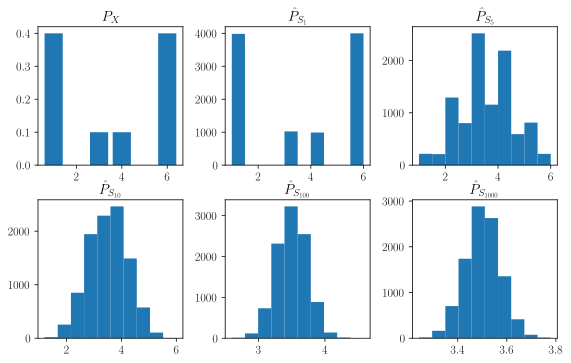

In [10]:
population = [1, 2, 3, 4, 5, 6]
PX = [0.4, 0, 0.1, 0.1, 0, 0.4]

def draw_from_PS(num_PX_samples):
    return np.random.choice(population, num_PX_samples, p=PX).mean()

fig, ax = plt.subplots(2, 3, figsize=(8, 5))
fig.tight_layout()

ax[0, 0].set(title=r"$P_X$")
ax[0, 1].set(title=r"$\hat P_{S_1}$")
ax[0, 2].set(title=r"$\hat P_{S_5}$")
ax[1, 0].set(title=r"$\hat P_{S_{10}}$")
ax[1, 1].set(title=r"$\hat P_{S_{100}}$")
ax[1, 2].set(title=r"$\hat P_{S_{1000}}$")

ax[0, 0].bar(population, PX)
ax[0, 1].hist([draw_from_PS(1) for _ in range(10000)])
ax[0, 2].hist([draw_from_PS(5) for _ in range(10000)])
ax[1, 0].hist([draw_from_PS(10) for _ in range(10000)])
ax[1, 1].hist([draw_from_PS(100) for _ in range(10000)])
ax[1, 2].hist([draw_from_PS(1000) for _ in range(10000)])

plt.show()

We notice that as we increase $N$, the number of samples from $P_X$, the shape of the $\hat P_S$ looks more and more Gaussian (tends towards 0 skew and kurtosis). It is important that we only trust $\hat P_S$ to approximate a Gaussian close to the mean, not in tails. For instance, in our example, $P_S(S<0)=P_S(S>6)=0$, whereas true Gaussians have infinite tails.

We also notice:
- $\hat P_S$ has the same mean as $P_X$, no matter the sample size $N$. Alternative notation: $\mu_{\hat S}=\mu_X$; The mean is $0.4 * 1 + 0.4 * 6 + 0.1 * 3 + 0.1 * 4 = 3.5$;
- $\hat P_S$ becomes "more normal" (lower skew and kurtosis) as $N$ increases;
- The variance $\hat\sigma^2_S$ of $\hat P_S$ decreases and $N$ increases; This is evidence that the variance $\sigma^2_S$ of the true distribution $P_S$ follows a similar trend.

Question: what is the relationship between $\sigma^2_S$ and $\sigma^2_X$? Since $S=\frac{1}{N}\sum_{n}X_n$, where $X_n$ is a sample from $P_X$, we have:
$$
\sigma^2_S = \frac{1}{N^2} \sum_n \sigma^2_X = \frac{1}{N^2} N \sigma^2_X = \frac{\sigma^2_X}{N} \Leftrightarrow \sigma_S = \frac{\sigma_X}{\sqrt N}.
$$


Note that we usually don't have $\sigma_X$. We can use those samples to construct $\hat P_S$. Of course we can also use them to construct $\hat P_X$. We have:
$$
\hat\sigma_S = \frac{\hat\sigma_X}{\sqrt N}.
$$

Note: the standard deviation $\hat\sigma_S$, i.e. the standard deviation of the sampling distribution $\hat P_S$ of the sample mean $S$ (where the "sample" in "sample mean" refers to samples $X$ from $P_X$) is also known as the **standard error on the mean**.

## Generalisation error

Generalisation is the ability of a learning algorithm $f$ to achieve low error on unseen data. Assume there is a distribution $p(\underline x, y)$ on future input-output pairs, that captures how the world works.

We define the generalisation error:
$$
\begin{align}
E_{gen} \triangleq \mathbb{E}_{p(\underline x, y)}L\left[y, f(\underline x)\right] &= \int\int p(\underline x, y) L\left[y, f(\underline x)\right] d\underline x dy \text{ (continuous)}\\
&\text{OR } \sum_{\underline x} \sum_y p(\underline x, y) L\left[y, f(\underline x)\right] \text{ (discrete)} \\
&\approx \frac{1}{M} \sum_{m=1}^M L\left[y^{(m)}, f(\underline x^{(m)})\right] \text{ (by Monte Carlo approximation)}\\
&=E_T
\end{align}
$$
where $T = \left\{ \left( \underline x^{(m)}, y^{(m)} \right) \sim p(\underline x, y) \big|_{m=1}^M\right\}$ is the test set, i.e. a set of $M$ independent samples from $p(\underline x, y)$, samples unseed during training. $L(y, f(\underline x))$ is the cost (aka loss) caused by classifying $\underline x$ as $y$, instead of $f(\underline x)$.

Question: How good is the estimate $E_T$ of $E_{gen}$? $\sigma_{E_T}$ can quantify that.

<img src="Machine Learning/img/2_generalisation_sem.svg" width="580"/>

- $E_T$ is the mean of $M$ samples from $P_L$;
- According to the CLT, the distrbution $P_{E_T}$ of $E_T$ approaches a Gaussian close to the mean;
- We also know that $\mu_{E_T}=\mu_L=E_{gen}$ and $\sigma_{E_T}=\frac{\sigma_L}{\sqrt{M}}$. Notation caution: recal that $\mu_X$ and $X$ both denote the mean of the distribution of random variable $X$.

So, our quantification for the goodness of the estimate $E_T$ of $E_{gen}$ as $\sigma_{E_T}$. While we do not have $\sigma_L$ that we need in computing $\sigma_{E_T}$, we can estimate $\sigma_L$ with $\hat\sigma_L$, computed from samples from $P_L$. Then, the estimate $\hat\sigma_{E_T}$ of $\sigma_{E_T}$ is:
$$
\hat\sigma_{E_T}=\frac{\hat\sigma_L}{\sqrt M}.
$$
The smaller this standard deviation, the higher the probability that our estimate of the generalisation error will be close to the the true generalisation error.

We know that in a Gaussian, about $2/3$ of the points are withing one standard deviation away from the mean. So, in our case, we expect out estimate $E_T$ of $E_{gen}$ to be within one $\frac{\sigma_L}{\sqrt M}$ (standard deviation) $2/3$ of the time (i.e. for two thirds of all possible test sets).
We also notice that $\sigma_{E_T}$ is inversely proportional to the size of the test set.

## Error bars and how to choose between models

Consider two models $A$ and $B$ and a validation set $V$. For instance, we could have two different architectures, or the same architecture with different regularisation constants. Say $E^{(A)}_V > E^{(B)}_V$. Does this mean $B$ is better than $A$? Is the validation set big enough to trust this? Could we be overfitting the validation set?

Say we compute the standard error of both estimates $E^{(A)}_V$ and $E^{(B)}_V$.

<img src="Machine Learning/img/2_generalisation_model_choice.svg" width="400"/>

Consulting the illustration above, we notice a big overlap between the error bars of $A$ and $B$. Because of this, naively speaking, $B$ is not necessarily better than $A$.

But, consider a few further points:
1. Say the difference between means above is $0.1$. If on every single example $B$ is better than $A$ by $0.1$, there is a high probability that this is not due to chance and B is indeed better than A; However, if the standard error of both A and B is big, we don't know exactly how good each model is;
2. On the other hand, if on some examples B is better and on other examples A is better, it's more difficult to say.

### Paired comparison

When the difference between the means above is small, it can be useful to do a paired comparison to check if it is significant.
Say the validation set $V$ has $M$ examples and let $\delta_m = L^{(A)}_m - L^{(B)}_m$, i.e. the difference in loss on example $m$ between A and B.
Consider the mean difference on the entire validation set $\Delta_V = \frac{1}{M} \sum_m \delta_m$.

**Question**: is the mean difference $\Delta_V$ significant? Let us consider $\Delta_V$ a random variable, taking one value for each validation set $V$. We can compute the standard error on the mean $\Delta_V$ as $\hat\sigma_{\Delta_V} = \frac{\hat\sigma_{\delta}}{\sqrt M}$. If this is large, we need a larger validation set to be confident that the $\Delta_V$ on our specific validation set $V$ is significant.

## Sources of variability in performance (on the same test set)

- Different _training_ (not test) sets;
- Different initialisations, or random choices during training;
- Floating point nondeterminism, e.g. in floating point, multiplication might not be commutative.
- GPU weirdness
- ...

Consider the experiment of initialising the model in 1000 different ways and computing the error on the same fixed validation set $V$. We interpret each such error as an instance of a random variable $R_V$. Observing the errors in each initialisation we can construct the sampling distribution $\hat P_{R_V}$, the distrbution of $R_V$ due to randomness.

- The standard deviation $\hat\sigma_{R_V}$ of this distribution measures how variable is the error on the same validation set $V$, due to randomness; The experiment is computing different instances of $R_V$, each on the same validation set, but with different random initialisations. The distribution of $R_V$ has nothing to do with a Gaussian;
- This is to be contrasted with the standard error on the mean, $\hat\sigma_{E_V}$. This one measures how well any instance of $E_V$, computed on one validation set, estimates $E_{gen}$. The experiment is computing different instances of $E_V$, each computation on its own validation set. The distribution of $E_V$ approximates a Gaussian.

<img src="Machine Learning/img/2_generalisation_variability.svg" width="650"/>

# The bias - variance tradeoff

The **bias** of a model is the error introduced by making the model too rigid. That is, embedding too many prior assumptions into the model. For instance using a linear model to approximate a quadratic relationship. Think of bias as the <u>rigidity</u> of a model.

The **variance** of a model is the amount by which <u>parameter estimation</u> would change if we changed the training data. Note that we assume all training data is coming from the same true distribution $p(\underline x, y)$.

The **bias-variance tradeoff**: bias is inversely proportional to variance.
- if a model has high bias it is less perceptive to different training data => low variance;
- if a model has high variance it is highly perceptive to different training data => low bias.

The ideal model has both low bias and low variance.

In the image below, the idea model area is the red one. Each blue dot represent the test error (on the same test set) of the same model trained on different sets, all sampled from the same true distribution $p(\underline x, y)$.

<img src="Machine Learning/img/2_generalisation_bias_variance_tradeoff.png" width="450"/>

(image source: https://scott.fortmann-roe.com/docs/BiasVariance.html)

# No free lunch theorem
The theorem states that all optimization algorithms perform equally well when their performance is averaged across all possible problems.

It implies that there is no single best optimization algorithm. Because of the close relationship between optimization, search, and machine learning, it also implies that there is no single best machine learning algorithm for predictive modeling problems such as classification and regression.

The implication is that the performance of your favorite algorithm is identical to a completely naive algorithm, such as random search. If one algorithm performs better than another algorithm on one class of problems, then it will perform worse on another class of problems.

## What's the catch?
- The catch is that the application of algorithms does not assume anything about the problem. In fact, algorithms are applied to objective functions with no prior knowledge, even such as whether the objective function is minimizing or maximizing. We often have some knowledge about the objective function being optimized. As elaborated by the no free lunch theorems of Wolpert and Macready, there is no reason to prefer one algorithm over another unless we make assumptions about the probability distribution over the space of possible objective functions.
- Additionally, the performance is averaged over all possible objective functions and all possible optimization algorithms. Whereas in practice, we are interested in a small subset of objective functions that may have a specific structure or form and algorithms tailored to those functions.

## Consequences
- As a consequence of the no free lunch theorem, we need to develop many different types of models, to cover the wide variety of data that occurs in the real world. And for each model, there may be many different algorithms we can use to train the model, which make different speed-accuracy-complexity tradeoffs.
- The practical consequence of the "no free lunch" theorem is that there’s no such thing as learning without knowledge. Data alone is not enough. A machine learning practitioner is encouraged to review the available data in order to learn something about the problem that can be incorporated into the learning algorithm.